In [1]:
# Load seed 21 results and combine them into one csv

import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

# === Step 1: Define folder and categorize CSVs ===
folder = "optimization_150000_seed21_results"
files = os.listdir(folder)

# Group files
favourable_files = [f for f in files if f.startswith("favourable_outcomes")]
unfavourable_files = [f for f in files if f.startswith("unfavourable_outcomes")]
medium_files = [f for f in files if f.startswith("medium_outcomes")]

# === Step 2: Helper function to load and combine files ===
def load_and_combine(file_list, label):
    dfs = []
    for file in file_list:
        df = pd.read_csv(os.path.join(folder, file))
        df['total costs'] = df['Expected Annual Damage'] + df['Dike Investment Costs'] + df['RfR Investment Costs'] + df['Evacuation Costs']
        df['scenario'] = label
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# === Step 3: Combine datasets ===
favourable_df_21 = load_and_combine(favourable_files, 'Favourable')
unfavourable_df_21 = load_and_combine(unfavourable_files, 'Unfavourable')
medium_df_21 = load_and_combine(medium_files, 'Medium')

medium_df_21.head()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,total costs,scenario
0,0,1,0,0,0,0,1,1,0,0,...,3,0,0,1.351245e+08,3.667233e+07,146000000.0,0.0,0.093794,3.177968e+08,Medium
1,0,1,1,0,0,0,0,1,0,0,...,0,0,0,7.152996e+08,0.000000e+00,199900000.0,0.0,0.620578,9.151996e+08,Medium
2,0,0,1,0,0,0,1,0,0,1,...,0,0,0,2.467534e+08,0.000000e+00,236500000.0,0.0,0.192439,4.832534e+08,Medium
3,0,1,0,0,0,0,0,0,0,1,...,1,0,0,1.918775e+08,2.503721e+07,205800000.0,0.0,0.145112,4.227147e+08,Medium
4,0,1,0,0,0,0,1,0,1,0,...,0,0,0,7.347813e+08,0.000000e+00,146000000.0,0.0,0.627542,8.807813e+08,Medium


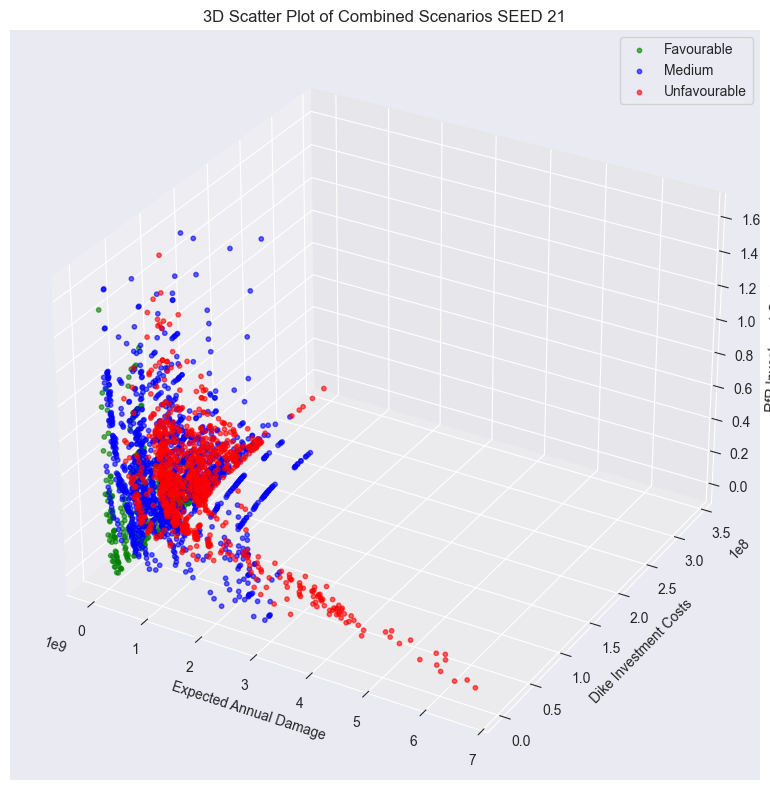

In [2]:
# === 3D SCATTER PLOT OF SCENARIOS (SEED 21) ===
# This plot visualizes the performance of policies under different scenario groups
# (Favourable, Medium, Unfavourable) in 3D space using three key metrics.

# === Step 4: Plot ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with a unique color
ax.scatter(favourable_df_21['Expected Annual Damage'], favourable_df_21['Dike Investment Costs'], favourable_df_21['RfR Investment Costs'],
           color='green', label='Favourable', alpha=0.6, s=10)

ax.scatter(medium_df_21['Expected Annual Damage'], medium_df_21['Dike Investment Costs'], medium_df_21['RfR Investment Costs'],
           color='blue', label='Medium', alpha=0.6, s=10)

ax.scatter(unfavourable_df_21['Expected Annual Damage'], unfavourable_df_21['Dike Investment Costs'], unfavourable_df_21['RfR Investment Costs'],
           color='red', label='Unfavourable', alpha=0.6, s=10)

# Labels and legend
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('Dike Investment Costs')
ax.set_zlabel('RfR Investment Costs')
ax.legend()

plt.title('3D Scatter Plot of Combined Scenarios SEED 21')
plt.tight_layout()
plt.show()


In [3]:
# === THRESHOLD SETTING AND FILTERING FUNCTIONS ===
# This section defines functions to calculate performance thresholds using quantiles
# and to filter the DataFrame based on those thresholds.

# --- Step 1: Define quantiles and compute thresholds for each metric ---
def load_thresholds(df, q_evac=0.6, q_total_cost=0.6, q_dike=0.6, q_damage=0.6, death_cap=0.025):
    # Add total costs as a new column
    df['total costs'] = (
        df['Expected Annual Damage'] +
        df['Dike Investment Costs'] +
        df['RfR Investment Costs'] +
        df['Evacuation Costs']
    )

    # Return the original DataFrame and a dictionary of threshold values
    return df, {
        'Evacuation Costs': df['Evacuation Costs'].quantile(q_evac),
        'total costs': df['total costs'].quantile(q_total_cost),
        'Dike Investment Costs': df['Dike Investment Costs'].quantile(q_dike),
        'Expected Annual Damage': df['Expected Annual Damage'].quantile(q_damage),
        'Expected Number of Deaths': death_cap  # Use a fixed cap instead of a quantile
    }

# --- Step 2: Filter the DataFrame based on threshold criteria ---
def filter_df(df, thresholds):
    # Return only rows that satisfy all threshold conditions
    return df[
        (df['Evacuation Costs'] <= thresholds['Evacuation Costs']) &
        (df['total costs'] <= thresholds['total costs']) &
        (df['Dike Investment Costs'] <= thresholds['Dike Investment Costs']) &
        (df['Expected Annual Damage'] <= thresholds['Expected Annual Damage']) &
        (df['Expected Number of Deaths'] <= thresholds['Expected Number of Deaths']) &
        (df['RfR Investment Costs'] > 0)  # Ensure non-zero RfR investments
    ]


In [4]:
# === SELECTING POLICIES BASED ON SCENARIO-SPECIFIC THRESHOLDS ===
# These thresholds are currently manually chosen to yield around 5 "favourable" policies.
# Consider revisiting and justifying the values based on decision criteria or expert input.

# --- Step 1: Load thresholds for the favourable scenario group (SEED 21) ---
fav_df, fav_thresholds = load_thresholds(
    favourable_df_21,
    q_evac=0.53,          # Slightly stricter than median
    q_total_cost=0.53,
    q_dike=0.53,
    q_damage=0.52,
    death_cap=0.025       # Fixed cap for expected deaths
)

# --- Step 2: Filter the favourable group DataFrame using those thresholds ---
fav_selected = filter_df(fav_df, fav_thresholds)

# --- Step 3: Display the number of selected policies and a quick preview ---
print(f"Filtered Favourable Policies: {len(fav_selected)} rows")
print(fav_selected[['scenario', 'total costs', 'Expected Number of Deaths']].head())


Filtered Favourable Policies: 5 rows
       scenario   total costs  Expected Number of Deaths
306  Favourable  2.439775e+08                   0.007905
319  Favourable  2.433437e+08                   0.007062
323  Favourable  1.295120e+08                   0.009651
337  Favourable  1.553232e+08                   0.006959
338  Favourable  1.600178e+08                   0.009937


In [5]:
# === SELECTING POLICIES FOR UNFAVOURABLE SCENARIOS BASED ON THRESHOLDS ===
# These thresholds should ideally be discussed or justified — currently chosen to yield ~5 policies.

# --- Step 1: Load thresholds for the unfavourable scenario group (SEED 21) ---
unfav_df, unfav_thresholds = load_thresholds(
    unfavourable_df_21,
    q_evac=0.56,          # Slightly above median to include more lenient solutions
    q_total_cost=0.56,
    q_dike=0.56,
    q_damage=0.56,
    death_cap=0.025       # Hard cap on deaths
)

# --- Step 2: Filter the unfavourable group DataFrame using those thresholds ---
unfav_selected = filter_df(unfav_df, unfav_thresholds)

# --- Step 3: Display the number of selected policies and a preview ---
print(f"Filtered Unfavourable Policies: {len(unfav_selected)} rows")
print(unfav_selected[['scenario', 'total costs', 'Expected Number of Deaths']].head())


Filtered Unfavourable Policies: 5 rows
         scenario   total costs  Expected Number of Deaths
335  Unfavourable  4.745046e+08                   0.017277
490  Unfavourable  4.500828e+08                   0.021905
789  Unfavourable  5.074229e+08                   0.022437
814  Unfavourable  4.801417e+08                   0.022737
829  Unfavourable  4.944688e+08                   0.007796


In [6]:
# === SELECTING POLICIES FOR MEDIUM SCENARIOS BASED ON THRESHOLDS ===
# These thresholds should be discussed or justified, currently chosen somewhat arbitrarily to get about 5 policies.

# --- Step 1: Load thresholds for the medium scenario group (SEED 21) ---
med_df, med_thresholds = load_thresholds(
    medium_df_21,
    q_evac=0.49,          # Quantile thresholds slightly below median for stricter filtering
    q_total_cost=0.49,
    q_dike=0.49,
    q_damage=0.49,
    death_cap=0.025       # Hard cap on expected number of deaths
)

# --- Step 2: Filter the medium group DataFrame using those thresholds ---
med_selected = filter_df(med_df, med_thresholds)

# --- Step 3: Display the number of selected policies and preview some columns ---
print(f"Filtered Medium Policies: {len(med_selected)} rows")
print(med_selected[['scenario', 'total costs', 'Expected Number of Deaths']].head())


Filtered Medium Policies: 5 rows
     scenario   total costs  Expected Number of Deaths
855    Medium  3.541906e+08                   0.017745
900    Medium  3.820674e+08                   0.017303
931    Medium  4.694238e+08                   0.007014
957    Medium  3.311095e+08                   0.018186
1000   Medium  3.036958e+08                   0.018628


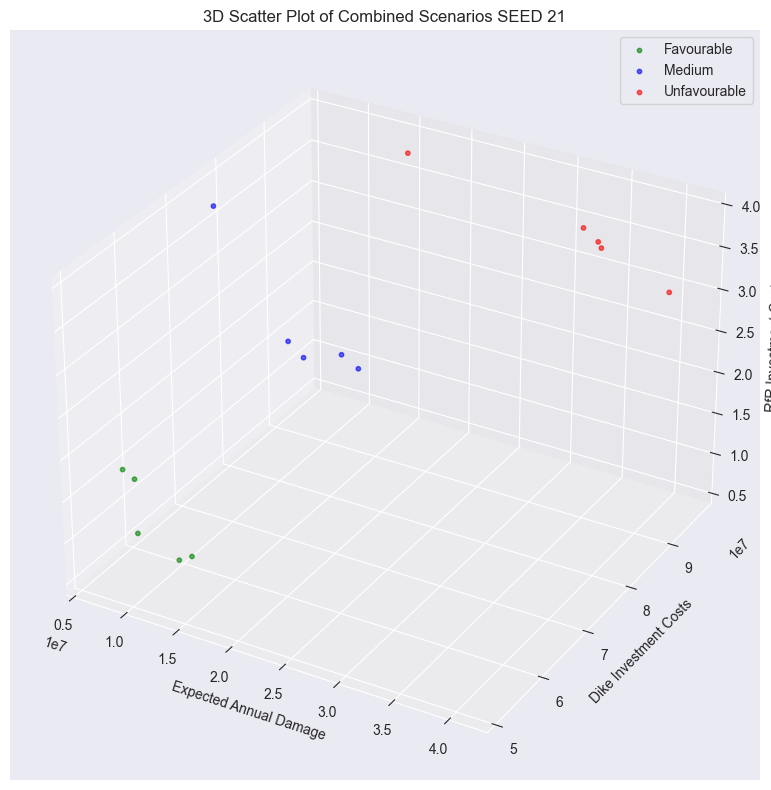

In [7]:
# === PLOT SELECTED POLICIES FROM DIFFERENT SCENARIO SETS IN 3D ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot favourable scenario policies in green
ax.scatter(
    fav_selected['Expected Annual Damage'],
    fav_selected['Dike Investment Costs'],
    fav_selected['RfR Investment Costs'],
    color='green', label='Favourable', alpha=0.6, s=10
)

# Plot medium scenario policies in blue
ax.scatter(
    med_selected['Expected Annual Damage'],
    med_selected['Dike Investment Costs'],
    med_selected['RfR Investment Costs'],
    color='blue', label='Medium', alpha=0.6, s=10
)

# Plot unfavourable scenario policies in red
ax.scatter(
    unfav_selected['Expected Annual Damage'],
    unfav_selected['Dike Investment Costs'],
    unfav_selected['RfR Investment Costs'],
    color='red', label='Unfavourable', alpha=0.6, s=10
)

# Set axis labels and legend
ax.set_xlabel('Expected Annual Damage')
ax.set_ylabel('Dike Investment Costs')
ax.set_zlabel('RfR Investment Costs')
ax.legend()

# Set plot title and layout then display
plt.title('3D Scatter Plot of Combined Scenarios SEED 21')
plt.tight_layout()
plt.show()


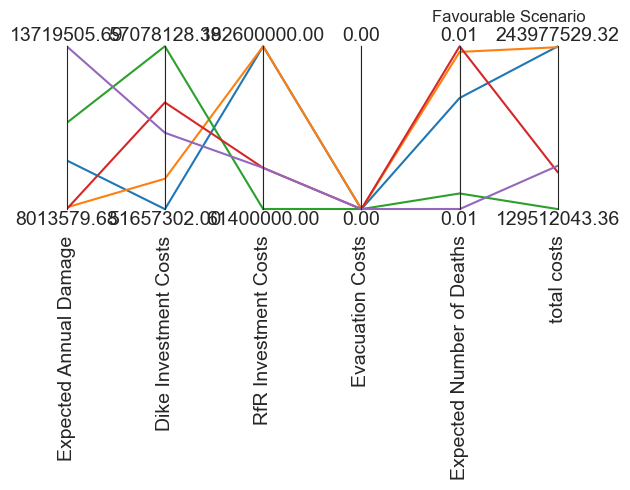

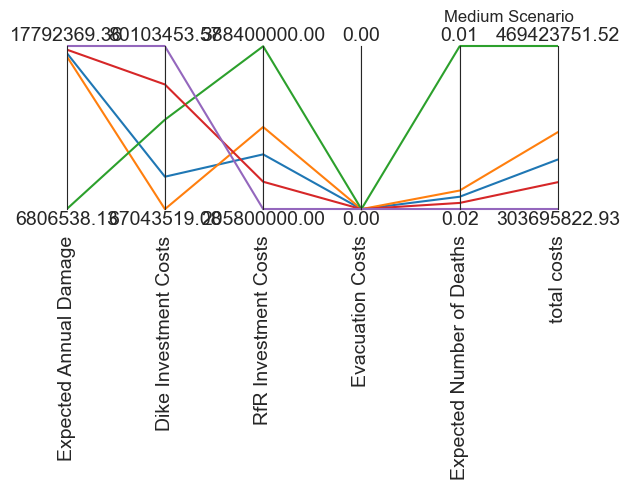

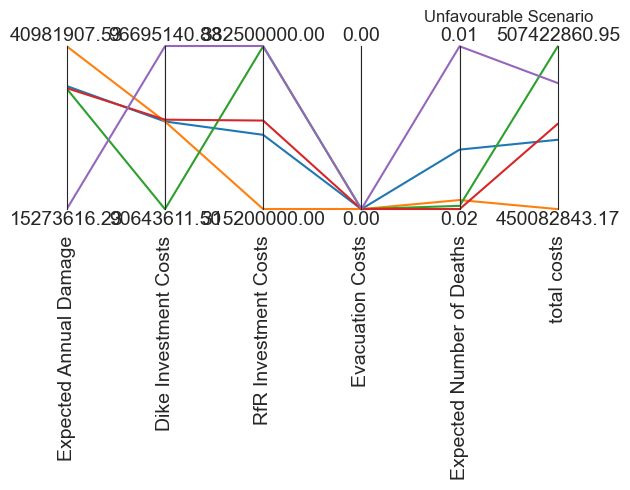

In [8]:
# === IMPORTS AND FUNCTION TO PLOT PARALLEL COORDINATES ===
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

def plot_parallel_coords(metrics_df, title="Parallel Coordinates Plot"):
    # Select only the last 7 columns from the DataFrame
    df_subset = metrics_df.iloc[:, -7:]

    # Keep only numeric columns to avoid issues with non-numeric data
    df_numeric = df_subset.select_dtypes(include=['number'])

    # Generate axis limits and initialize parallel coordinates plot
    limits = parcoords.get_limits(df_numeric)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(df_numeric)

    # Invert the axis for 'Expected Number of Deaths' to improve readability if present
    if 'Expected Number of Deaths' in df_numeric.columns:
        axes.invert_axis('Expected Number of Deaths')

    # Set plot title and show the plot
    plt.title(title)
    plt.show()

# === USAGE: Plot for each scenario category ===
plot_parallel_coords(fav_selected, "Favourable Scenario")
plot_parallel_coords(med_selected, "Medium Scenario")
plot_parallel_coords(unfav_selected, "Unfavourable Scenario")


In [9]:
import os
from datetime import datetime

# === Function to save filtered policy DataFrames as CSV files ===
def save_policy_csv(results_df, prefix, save=True):
    # Extract policy columns (exclude last 7 outcome columns)
    policy = results_df.iloc[:, :-7]

    # Format current date for filename
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Create folder if it doesn't exist
    folder_name = "policies"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save policy DataFrame to CSV if save=True
    if save:
        filename = os.path.join(folder_name, f"{prefix}policy_{current_date}.csv")
        policy.to_csv(filename, index=False)
        print(f"Policy saved to: {filename}")

# === Save each filtered policy DataFrame with appropriate prefix ===
save_policy_csv(fav_selected, "favourable_21_")
save_policy_csv(med_selected, "medium_21_")
save_policy_csv(unfav_selected, "unfavourable_21_")


Policy saved to: policies\favourable_21_policy_2025-06-14.csv
Policy saved to: policies\medium_21_policy_2025-06-14.csv
Policy saved to: policies\unfavourable_21_policy_2025-06-14.csv


In [10]:
# === Import necessary libraries ===
import pandas as pd
import matplotlib.pyplot as plt
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

# === Load the dike model and planning steps for problem formulation 2 ===
dike_model, planning_steps = get_model_for_problem_formulation(2)

# === Load the filtered original scenarios from CSV file ===
scenario_collection_df = pd.read_csv("scenarios/filtered_scenario_space_20.csv")

# === Combine the selected policy DataFrames into one collection (excluding outcome columns) ===
policy_collection_21_df = pd.concat([fav_selected, med_selected, unfav_selected], ignore_index=False).iloc[:, :-7]


In [11]:
# === Import necessary libraries ===
from datetime import datetime
import os
import pandas as pd
from ema_workbench import Policy, Scenario, MultiprocessingEvaluator
from problem_formulation import get_model_for_problem_formulation

# === Define a function to run each policy across all scenarios ===
def run_policies_in_scenarios(dike_model, policy_df, scenario_df):
    # Create an output folder with timestamp to save results
    output_folder = f"policy_scenario_results_21_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
    os.makedirs(output_folder, exist_ok=True)

    # Loop over all policies in the policy DataFrame
    for i, (idx, policy_row) in enumerate(policy_df.iterrows()):
        print(f"Running policy {i}...")

        # Create a Policy object from the current policy row
        policy = Policy(f"policy_{i}", **policy_row.to_dict())

        # Convert each scenario row into a Scenario object and store in a list
        scenarios = []
        for j, scenario_row in scenario_df.iterrows():
            scenario = Scenario(f"scenario_{j}", **scenario_row.to_dict())
            scenarios.append(scenario)

        # Run the model experiments with MultiprocessingEvaluator for speed
        with MultiprocessingEvaluator(dike_model) as evaluator:
            experiments, outcomes = evaluator.perform_experiments(
                scenarios=scenarios,
                policies=[policy]
            )

        # Combine experiment input parameters with their outcomes into one DataFrame
        results_df = pd.DataFrame(experiments)
        for outcome_name, outcome_values in outcomes.items():
            results_df[outcome_name] = outcome_values

        # Save results for the current policy as CSV in the output folder
        filename = os.path.join(output_folder, f"policy_{i}_results.csv")
        results_df.to_csv(filename, index=False)
        print(f"Saved results for policy {i} to {filename}")

# === Load the model and planning steps ===
model, steps = get_model_for_problem_formulation(2)

# === Execute the function to run all policies on all scenarios ===
run_policies_in_scenarios(model, policy_collection_21_df, scenario_collection_df)

Running policy 0...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.65it/s]


Saved results for policy 0 to policy_scenario_results_21_2025-06-14_21-05\policy_0_results.csv
Running policy 1...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]


Saved results for policy 1 to policy_scenario_results_21_2025-06-14_21-05\policy_1_results.csv
Running policy 2...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


Saved results for policy 2 to policy_scenario_results_21_2025-06-14_21-05\policy_2_results.csv
Running policy 3...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.44it/s]


Saved results for policy 3 to policy_scenario_results_21_2025-06-14_21-05\policy_3_results.csv
Running policy 4...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.90it/s]


Saved results for policy 4 to policy_scenario_results_21_2025-06-14_21-05\policy_4_results.csv
Running policy 5...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.40it/s]


Saved results for policy 5 to policy_scenario_results_21_2025-06-14_21-05\policy_5_results.csv
Running policy 6...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


Saved results for policy 6 to policy_scenario_results_21_2025-06-14_21-05\policy_6_results.csv
Running policy 7...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  9.37it/s]


Saved results for policy 7 to policy_scenario_results_21_2025-06-14_21-05\policy_7_results.csv
Running policy 8...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


Saved results for policy 8 to policy_scenario_results_21_2025-06-14_21-05\policy_8_results.csv
Running policy 9...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.42it/s]


Saved results for policy 9 to policy_scenario_results_21_2025-06-14_21-05\policy_9_results.csv
Running policy 10...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.45it/s]


Saved results for policy 10 to policy_scenario_results_21_2025-06-14_21-05\policy_10_results.csv
Running policy 11...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.21it/s]


Saved results for policy 11 to policy_scenario_results_21_2025-06-14_21-05\policy_11_results.csv
Running policy 12...


100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  8.48it/s]


Saved results for policy 12 to policy_scenario_results_21_2025-06-14_21-05\policy_12_results.csv
Running policy 13...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.77it/s]


Saved results for policy 13 to policy_scenario_results_21_2025-06-14_21-05\policy_13_results.csv
Running policy 14...


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.63it/s]


Saved results for policy 14 to policy_scenario_results_21_2025-06-14_21-05\policy_14_results.csv


In [13]:
# Based on Jesse and Twan's code in Robustnesscheckpolicies.ipynb and chat combination. NEEDS TO BE DISCUSSED

import os
import pandas as pd

def evaluate_minimization(df, policy_id_col, scenario_id_col, performance_cols):
    """
    Evaluate policies by calculating mean and std for each performance metric,
    normalize means, and combine into a single score to find the best (lowest) overall.
    """
    grouped = df.groupby(policy_id_col)
    results = []

    # Calculate metrics for each policy
    for policy, group in grouped:
        metrics = {'Policy': policy}

        for col in performance_cols:
            values = group[col]
            metrics[f'{col} Mean'] = values.mean()
            metrics[f'{col} Std'] = values.std()

        results.append(metrics)

    robustness_df = pd.DataFrame(results)

    # Normalize mean values across policies to range [0,1]
    for col in performance_cols:
        mean_col = f'{col} Mean'
        robustness_df[f'{mean_col} (Norm)'] = (
            (robustness_df[mean_col] - robustness_df[mean_col].min()) /
            (robustness_df[mean_col].max() - robustness_df[mean_col].min())
        )

    # Sum normalized means to get a combined score (lower is better)
    robustness_df['Combined Score'] = robustness_df[[f'{c} Mean (Norm)' for c in performance_cols]].sum(axis=1)

    return robustness_df


def find_best_policy(folder_path):
    """
    Reads all *_results.csv files in a folder, concatenates them,
    calculates robustness metrics, and selects the best policy by combined score.
    """
    all_dfs = []

    # Load and preprocess all result CSV files in the folder
    for file in os.listdir(folder_path):
        if file.endswith("_results.csv"):
            policy_id = file.replace("_results.csv", "")
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            # Add policy and scenario identifiers and compute total costs
            df['policy'] = policy_id
            df['scenario'] = df.index
            df['Total Costs'] = (
                df['Expected Annual Damage'] +
                df['Dike Investment Costs'] +
                df['RfR Investment Costs'] +
                df['Evacuation Costs']
            )
            all_dfs.append(df)

    if not all_dfs:
        raise ValueError("No result CSV files found.")

    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Define performance columns to evaluate
    performance_columns = [
        'Expected Annual Damage',
        'Dike Investment Costs',
        'RfR Investment Costs',
        'Evacuation Costs',
        'Expected Number of Deaths',
        'Total Costs'
    ]

    # Evaluate minimization metrics for each policy
    robustness_df = evaluate_minimization(
        combined_df,
        policy_id_col='policy',
        scenario_id_col='scenario',
        performance_cols=performance_columns
    )

    # Select the best policy by lowest combined score
    best_policy_row = robustness_df.sort_values('Combined Score').iloc[0]
    best_policy_id = best_policy_row['Policy']

    print(f"\nBest policy (minimization only): {best_policy_id}")
    print("\nDetails:")
    print(best_policy_row)

    # Return best policy ID and its corresponding DataFrame subset
    return best_policy_id, combined_df[combined_df['policy'] == best_policy_id]

# Specify the folder containing policy results CSVs
output_folder = "policy_scenario_42_results_21_2025-06-14"

# Run the function to find the best policy and get its detailed results
best_policy, best_policy_df = find_best_policy(output_folder)



🏆 Best policy (minimization only): policy_13

🔍 Details:
Policy                                          policy_13
Expected Annual Damage Mean              448868284.378514
Expected Annual Damage Std               821792724.790814
Dike Investment Costs Mean                93967624.970788
Dike Investment Costs Std                             0.0
RfR Investment Costs Mean                     351800000.0
RfR Investment Costs Std                              0.0
Evacuation Costs Mean                                 0.0
Evacuation Costs Std                                  0.0
Expected Number of Deaths Mean                   0.324334
Expected Number of Deaths Std                    0.547178
Total Costs Mean                         894635909.349302
Total Costs Std                          821792724.790814
Expected Annual Damage Mean (Norm)               0.008446
Dike Investment Costs Mean (Norm)                0.939439
RfR Investment Costs Mean (Norm)                 0.888073
Evacuation Cos